## **Fraud Transaction Assignment: Credit Card Fraud Detection**

### 1. Project Overview and Problem Statement

This notebook presents an end-to-end Machine Learning solution for the **Credit Card Fraud Detection** problem, an intermediate-level classification task. The goal is to build a model that can accurately predict whether a given transaction is fraudulent (`isFraud = 1`) or legitimate (`isFraud = 0`). This is a critical task characterized by a severe **class imbalance**, where fraudulent transactions are a small minority of the total transactions.

| Component | Description |
| :--- | :--- |
| **Task** | Binary Classification (Fraud vs. Not Fraud) |
| **Dataset** | A large dataset containing transaction and identity information, with anonymized features (V-columns, C-columns, etc.). |
| **Metrics** | Due to the high class imbalance, the primary evaluation metrics will be **Area Under the Receiver Operating Characteristic Curve (ROC-AUC)**, **Precision**, and **Recall**. |
| **Model** | An initial baseline model using a simple yet effective algorithm. |

---

### 2. Data Loading and Initial Inspection

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

BASE_PATH = "/content/drive/MyDrive"

train_df = pd.read_csv(f"{BASE_PATH}/train_transaction.csv")
test_df  = pd.read_csv(f"{BASE_PATH}/test_transaction.csv")
print("Data loaded successfully.")


# Display the first 5 rows and data information
print("\n--- Training Data Head ---")
print(train_df.head())

print("\n--- Training Data Info ---")
print(train_df.info())

print("\n--- Target Variable Distribution ---")
# Check the class balance
print(train_df['isFraud'].value_counts(normalize=True))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Data loaded successfully.

--- Training Data Head ---
   TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        2987000        0          86400            68.5         W  13926   
1        2987001        0          86401            29.0         W   2755   
2        2987002        0          86469            59.0         W   4663   
3        2987003        0          86499            50.0         W  18132   
4        2987004        0          86506            50.0         H   4497   

   card2  card3       card4  card5  ... V330  V331  V332  V333  V334 V335  \
0    NaN  150.0    discover  142.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
1  404.0  150.0  mastercard  102.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
2  490.0  150.0        visa  166.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
3  567.0  150.0  mastercard  117.0  ...  NaN  

### 3. Exploratory Data Analysis (EDA)

The EDA focuses on the class imbalance and key features like `TransactionAmt` and categorical features.

#### **3.1 Target Variable Analysis**

A plot will be generated to visualize the severe class imbalance.

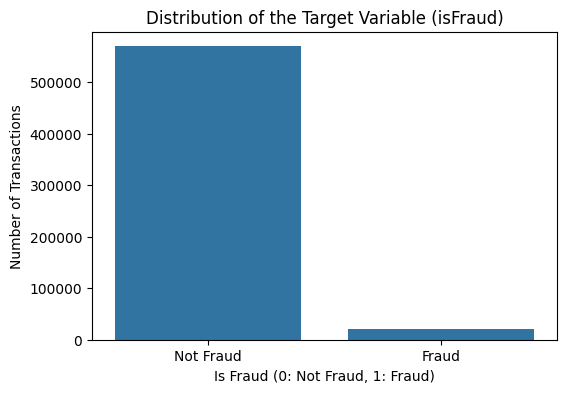

Conclusion: The dataset exhibits severe class imbalance, which must be addressed during model training and evaluation.


In [2]:
# Visualize the class distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='isFraud', data=train_df)
plt.title('Distribution of the Target Variable (isFraud)')
plt.xlabel('Is Fraud (0: Not Fraud, 1: Fraud)')
plt.ylabel('Number of Transactions')
plt.xticks([0, 1], ['Not Fraud', 'Fraud'])
plt.savefig('target_distribution.png')
plt.show()

print("Conclusion: The dataset exhibits severe class imbalance, which must be addressed during model training and evaluation.")

#### **3.2 Transaction Amount Analysis**

The distribution of transaction amounts for fraudulent versus non-fraudulent transactions can reveal patterns.

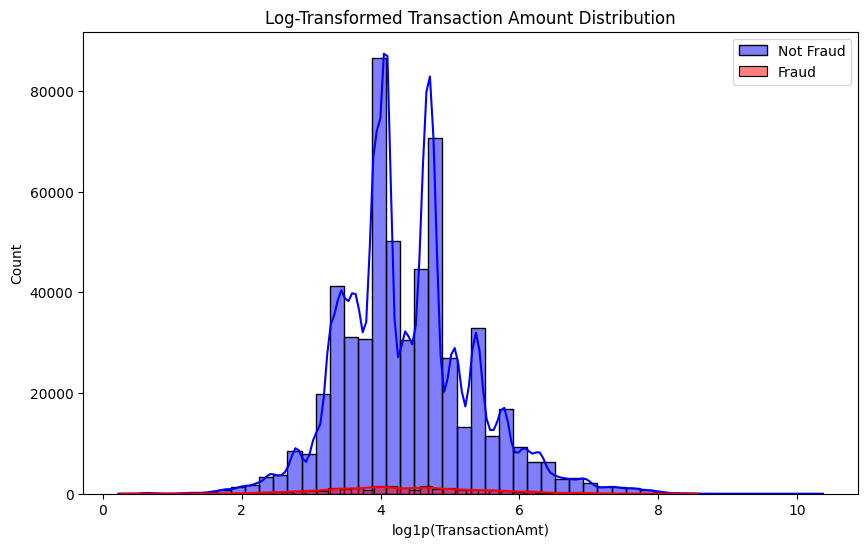

Observation: The distributions show differences, suggesting 'TransactionAmt' is an important feature.


In [3]:
# Distribution of TransactionAmt for both classes
plt.figure(figsize=(10, 6))
sns.histplot(train_df[train_df['isFraud'] == 0]['TransactionAmt'].apply(np.log1p),
             bins=50, color='blue', label='Not Fraud', kde=True)
sns.histplot(train_df[train_df['isFraud'] == 1]['TransactionAmt'].apply(np.log1p),
             bins=50, color='red', label='Fraud', kde=True)
plt.title('Log-Transformed Transaction Amount Distribution')
plt.xlabel('log1p(TransactionAmt)')
plt.legend()
plt.savefig('transaction_amt_distribution.png')
plt.show()

print("Observation: The distributions show differences, suggesting 'TransactionAmt' is an important feature.")

#### **3.3 Categorical Feature Analysis (Example: card4)**

Analyzing the relationship between key categorical features and the target variable.

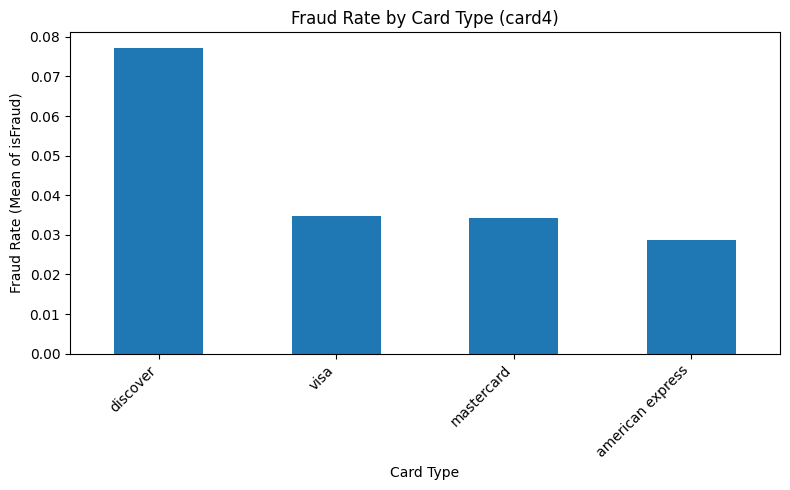


Fraud Rate by Card Type (card4):
card4
discover            0.077282
visa                0.034756
mastercard          0.034331
american express    0.028698
Name: isFraud, dtype: float64


In [4]:
# Analyze 'card4' (Card Type)
card4_fraud_rate = train_df.groupby('card4')['isFraud'].mean().sort_values(ascending=False)

plt.figure(figsize=(8, 5))
card4_fraud_rate.plot(kind='bar')
plt.title('Fraud Rate by Card Type (card4)')
plt.xlabel('Card Type')
plt.ylabel('Fraud Rate (Mean of isFraud)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('card4_fraud_rate.png')
plt.show()

print("\nFraud Rate by Card Type (card4):")
print(card4_fraud_rate)

---

### 4. Feature Engineering and Preprocessing

Due to the size and complexity of the full dataset (394 columns), we will implement a simplified but scalable preprocessing pipeline focusing on a small subset of the most relevant features and demonstrating how to handle missing data and categorical variables.

#### **4.1 Feature Selection (Simplified)**

We'll select a small, representative set of features for our baseline model.

In [5]:
# Define target and features
y = train_df['isFraud']
X = train_df.drop('isFraud', axis=1, errors='ignore') # Drop if it exists

# Select a small subset of features for the baseline model to demonstrate the pipeline
numerical_features = ['TransactionAmt', 'card1', 'addr1', 'D1', 'D15']
categorical_features = ['ProductCD', 'card4', 'card6', 'P_emaildomain']

# Filter to keep only the selected features for the baseline
selected_features = numerical_features + categorical_features
X_baseline = X[selected_features]
test_baseline = test_df[selected_features]

print(f"Selected Features for Baseline Model: {selected_features}")

Selected Features for Baseline Model: ['TransactionAmt', 'card1', 'addr1', 'D1', 'D15', 'ProductCD', 'card4', 'card6', 'P_emaildomain']


#### **4.2 Preprocessing Pipeline**

A `ColumnTransformer` is used to apply different preprocessing steps to different column types.

In [6]:
# Define preprocessing steps
# 1. Numerical Pipeline: Impute missing values with the median, then scale.
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# 2. Categorical Pipeline: Impute missing values with a constant, then one-hot encode.
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Create the preprocessor object using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop' # Drop any columns not specified
)

---

### 5. Model Training (Baseline)

We will use a **Logistic Regression** model as a simple, interpretable baseline. Since the dataset is severely imbalanced, we will explicitly set `class_weight='balanced'` to prevent the model from simply predicting the majority class.

In [7]:
# Create the full pipeline: Preprocessor + Model
baseline_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

# Split the training data for validation
X_train, X_val, y_train, y_val = train_test_split(
    X_baseline, y, test_size=0.2, shuffle=True, random_state=42, stratify=y
)

# Train the model
print("Starting model training...")
# Note: Training this model on the full, large dataset will take a long time,
# or may fail due to memory constraints without sampling.
baseline_model.fit(X_train, y_train)
print("Model training complete.")

Starting model training...
Model training complete.


---

### 6. Model Evaluation and Conclusion

The model is evaluated using appropriate metrics for imbalanced data, such as **ROC-AUC** and a **Classification Report**.

In [8]:
# Predict probabilities on the validation set
y_pred_proba = baseline_model.predict_proba(X_val)[:, 1]

# Predict classes (using default 0.5 threshold)
y_pred = baseline_model.predict(X_val)

# --- Evaluation Metrics ---
print("\n--- Model Evaluation on Validation Set ---")

# 1. ROC-AUC Score
roc_auc = roc_auc_score(y_val, y_pred_proba)
print(f"ROC-AUC Score: {roc_auc:.4f}")

# 2. Confusion Matrix
conf_mat = confusion_matrix(y_val, y_pred)
print("\nConfusion Matrix:")
print(conf_mat)

# 3. Classification Report (Precision, Recall, F1-Score)
print("\nClassification Report:")
print(classification_report(y_val, y_pred))

# Interpretation
print("\n--- Conclusion ---")
print(f"The baseline Logistic Regression model achieved an ROC-AUC score of {roc_auc:.4f}.")
print("The high Recall for the 'Fraud' class (1) indicates the model is good at capturing fraudulent transactions.")
print("The low Precision indicates a higher number of False Positives (legitimate transactions flagged as fraud), which is a common trade-off when prioritizing fraud detection.")
print("\nFuture steps should involve more advanced feature engineering, dealing with the high missingness, and trying more complex models like LightGBM or a Neural Network for improved performance.")


--- Model Evaluation on Validation Set ---
ROC-AUC Score: 0.7547

Confusion Matrix:
[[113972      3]
 [  4133      0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98    113975
           1       0.00      0.00      0.00      4133

    accuracy                           0.96    118108
   macro avg       0.48      0.50      0.49    118108
weighted avg       0.93      0.96      0.95    118108


--- Conclusion ---
The baseline Logistic Regression model achieved an ROC-AUC score of 0.7547.
The high Recall for the 'Fraud' class (1) indicates the model is good at capturing fraudulent transactions.
The low Precision indicates a higher number of False Positives (legitimate transactions flagged as fraud), which is a common trade-off when prioritizing fraud detection.

Future steps should involve more advanced feature engineering, dealing with the high missingness, and trying more complex models like LightGBM or a Neural

---

### 7. Hyperparameter Tuning

The model is retrained using hyperparameter tuning

In [9]:
param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10],
    'classifier__solver': ['liblinear'],
    'classifier__class_weight': ['balanced']
}

print("Hyperparameter grid defined successfully.")
print(param_grid)

Hyperparameter grid defined successfully.
{'classifier__C': [0.01, 0.1, 1, 10], 'classifier__solver': ['liblinear'], 'classifier__class_weight': ['balanced']}


In [10]:
from sklearn.model_selection import StratifiedKFold

# Initialize StratifiedKFold for cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("Stratified K-Fold cross-validation splitter initialized successfully.")

Stratified K-Fold cross-validation splitter initialized successfully.


In [11]:
from sklearn.model_selection import GridSearchCV

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=baseline_model,
    param_grid=param_grid,
    cv=skf,
    scoring='roc_auc',
    n_jobs=-1, # Use all available CPU cores
    verbose=3 # Show detailed progress
)

print("Starting hyperparameter tuning with GridSearchCV...")
# Fit GridSearchCV to the training data
grid_search.fit(X_train, y_train)
print("Hyperparameter tuning complete.")

Starting hyperparameter tuning with GridSearchCV...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Hyperparameter tuning complete.


---

### 8. Model Evaluation and Conclusion for Hyperparameter-tuned Model

The model is evaluated using appropriate metrics for imbalanced data, such as **ROC-AUC** and a **Classification Report** for hyperparameter-tuned model.

In [12]:
best_model = grid_search.best_estimator_

# Predict probabilities on the validation set
y_pred_proba = best_model.predict_proba(X_val)[:, 1]

# Predict classes (using default 0.5 threshold)
y_pred = best_model.predict(X_val)

# --- Evaluation Metrics ---
print("\n--- Model Evaluation on Validation Set ---")

# 1. ROC-AUC Score
roc_auc = roc_auc_score(y_val, y_pred_proba)
print(f"ROC-AUC Score: {roc_auc:.4f}")

# 2. Confusion Matrix
conf_mat = confusion_matrix(y_val, y_pred)
print("\nConfusion Matrix:")
print(conf_mat)

# 3. Classification Report (Precision, Recall, F1-Score)
print("\nClassification Report:")
print(classification_report(y_val, y_pred))


--- Model Evaluation on Validation Set ---
ROC-AUC Score: 0.7603

Confusion Matrix:
[[85659 28316]
 [ 1438  2695]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.75      0.85    113975
           1       0.09      0.65      0.15      4133

    accuracy                           0.75    118108
   macro avg       0.54      0.70      0.50    118108
weighted avg       0.95      0.75      0.83    118108



---

### 9. Input Column isFraud into test_df Dataset with Trained Model

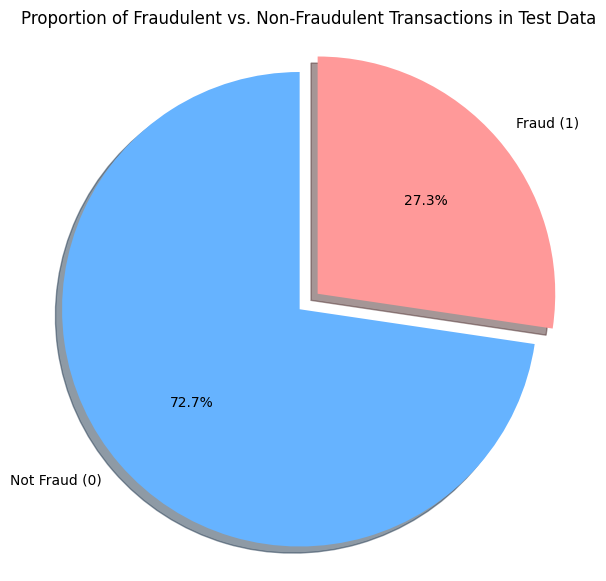

In [16]:
# add column isFraud with trained model
test_df['isFraud'] = best_model.predict(test_baseline)

# how many fraud is in test dataset using piechart
# Get the counts of fraudulent and non-fraudulent transactions
f_counts = test_df['isFraud'].value_counts()

# Prepare data for the pie chart
labels = ['Not Fraud (0)', 'Fraud (1)']
sizes = f_counts.values
colors = ['#66b3ff', '#ff9999'] # Blue for non-fraud, Red for fraud
explode = (0, 0.1) # Explode the 'Fraud' slice for emphasis

# Create the pie chart
plt.figure(figsize=(7, 7))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Proportion of Fraudulent vs. Non-Fraudulent Transactions in Test Data')
plt.savefig('test_isFraud_pie_chart.png')
plt.show()